# <center> <span style="color: #ec008a"> <b> Sentiment Analysis <br> Shopee Review - Vietnamese

**I. Objective**
- This project aims to perform sentiment analysis on Vietnamese text
- Project uses PhoBERT for feature extraction, and choosing among Logistic Regression, Decision Tree and Random Forest for classification

**II. Dataset**
- [Kaggle | Vietnamese sentiment analyst](https://www.kaggle.com/datasets/linhlpv/vietnamese-sentiment-analyst/data)
- Customer Shopee reviews are label positive, negative or neutral

**III. Steps** 

***1. Data Preprocessing***
- The dataset is loaded and cleaned by removing rows with missing values.
- Labels are converted to numerical values 

***2. Feature Extraction***
- PhoBERT, a pre-trained language model for Vietnamese, is used to extract text embeddings.
- The extract_embedding_batch function tokenizes the text and extracts embeddings using PhoBERT.

***3. Model Training***
- Logistic Regression is employed as the classification model.
- The model is trained on the extracted embeddings and corresponding labels.

***4. Evaluation***
- The model's performance is evaluated on a test set using accuracy and classification report metrics.

***5. Prediction***
- The trained model is saved and can be loaded for predicting sentiment on new text samples.
- The model predicts the sentiment label (Positive, Negative, or Neutral) for a given input.

**References**
- [Vietnamese correction](https://github.com/bmd1905/vietnamese-correction/?tab=readme-ov-file)
- [PhoBERT](https://github.com/VinAIResearch/PhoBERT?tab=readme-ov-file#introduction)

In [1]:
!pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle

In [3]:
#!pip install torch transformers scikit-learn
import torch
from transformers import AutoTokenizer, AutoModel

# Importing data

In [ ]:
data = pd.read_csv('....../dataset/data.csv', usecols=['content', 'label'], encoding='utf8')
data

,content,label
0,Áo bao đẹp ạ!,POS
1,Tuyệt vời,POS
2,2day ao khong giong trong,NEG
3,"Mùi thơm,bôi lên da mềm da",POS
4,"Vải đẹp, dày dặn",POS
...,...,...
31455,Không đáng tiền,NEG
31456,Quần rất đẹp,POS
31457,Hàng đẹp đúng giá tiền,POS
31458,Chất vải khá ổn,POS


# Data cleaning

In [5]:
# Count missing value
data.isnull().sum()

content    24
label       0
dtype: int64

In [6]:
# Delete row containing null value
data = data.dropna(subset=['content'])

# Checking the data
print("\nMissing values after cleaning:")
print(data.isnull().sum())

data.shape


Missing values after cleaning:
content    0
label      0
dtype: int64


(31436, 2)

In [7]:
data['label'].value_counts()

label
POS    20078
NEG     6664
NEU     4694
Name: count, dtype: int64

In [8]:
#hide the SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Rename label POS: 1, NEG: -1, NEU: 0
data.replace({'label':{'POS': 1}}, inplace = True)
data.replace({'label':{'NEG':-1}}, inplace = True)
data.replace({'label':{'NEU': 0}}, inplace = True)
data['label'].value_counts()

label
 1    20078
-1     6664
 0     4694
Name: count, dtype: int64

## Case folding and lowercasing

Since lettercase does not significantly impact PhoBert performance, it is unnecessary

In [9]:
# case folding and lowercasing
def casefolding(content):
    content = content.lower()
    return content
data['lowercasecontent'] = data['content'].apply(casefolding)
data.head()

,content,label,lowercasecontent
0,Áo bao đẹp ạ!,1,áo bao đẹp ạ!
1,Tuyệt vời,1,tuyệt vời
2,2day ao khong giong trong,-1,2day ao khong giong trong
3,"Mùi thơm,bôi lên da mềm da",1,"mùi thơm,bôi lên da mềm da"
4,"Vải đẹp, dày dặn",1,"vải đẹp, dày dặn"


## Spelling correction

In [10]:
from transformers import pipeline
import sentencepiece

corrector = pipeline("text2text-generation", model="bmd1905/vietnamese-correction-v2")

In [11]:
# predictions = corrector(data['content'].tolist(), max_length=512)
# data['content_spellchecked'] = [item['generated_text'] for item in predictions]

# Split data

In [12]:
# separating the data and label
X = data['lowercasecontent'].values
Y = data['label'].values
print(X)
print(Y)

['áo bao đẹp ạ!' 'tuyệt vời' '2day ao khong giong trong' ...
 'hàng đẹp đúng giá tiền' 'chất vải khá ổn'
 'áo rất ok nhé , vải mịn , len cao cổ này phối form mùa đông thì quá chất m.ng nhé']
[ 1  1 -1 ...  1  1  1]


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

# Tokenise data

In [14]:
# Using PhoBERT to tokenise data
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
phobert.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [15]:
# Example text
text = "Sản phẩm không có gì nổi bật, phí tiền"

# Tokenise the text
tokenised_text = tokenizer.tokenize(text)

# Show result
tokenised_text

['Sản', 'phẩm', 'không', 'có', 'gì', 'nổi', 'bậ@@', 't@@', ',', 'phí', 'tiền']

In [16]:
#Split each Data to each Batch
def extract_embedding_batch(texts, batch_size=16):
    embeddings = []

    # Convert NumPy array to list of strings if needed
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    for i in range(0, len(texts), batch_size):
        # 1 batch of texts
        batch_texts = texts[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        # Extract embedding with PhoBERT
        with torch.no_grad():
            output = phobert(**inputs.to(device)).last_hidden_state  # Using GPU
            embedding = output[:, 0, :].cpu().numpy()  # Take vector [CLS]
            embeddings.append(embedding)

    return np.vstack(embeddings)  # convert to numpy matrix

In [17]:
example_e = extract_embedding_batch(tokenised_text)
example_e

array([[-0.02633106,  0.619721  , -0.07678566, ..., -0.01255018,
         0.3616438 , -0.21706977],
       [ 0.35948592,  0.63817495, -0.1974679 , ..., -0.13690792,
         0.19644156, -0.15896177],
       [ 0.19359411,  0.38780585, -0.15351999, ..., -0.34493554,
         0.24038798,  0.3012499 ],
       ...,
       [-0.01503592,  0.29828283, -0.07736006, ..., -0.26753294,
         0.14798018,  0.2392481 ],
       [ 0.03198723,  0.3854237 , -0.2657916 , ..., -0.38207263,
         0.35352314,  0.05567088],
       [ 0.2586059 ,  0.4130236 , -0.4783277 , ..., -0.17641847,
         0.38490504,  0.08206291]], dtype=float32)

In [18]:
# Extract embedding from X_train and X_test
X_train_e = extract_embedding_batch(X_train)
X_test_e = extract_embedding_batch(X_test)
print(X_train_e)
print(X_test_e)

[[ 0.14948149  0.6955161  -0.10189895 ... -0.02970904  0.33563164
   0.5417839 ]
 [ 0.32684574  0.612622   -0.14774811 ... -0.32424593  0.26552653
   0.48563996]
 [ 0.06069205  0.28247914  0.11787552 ... -0.05494553  0.44723102
   0.34448925]
 ...
 [ 0.11354098  0.67193735 -0.03206758 ... -0.17107306  0.22111131
   0.08721744]
 [ 0.1022791   0.43144223  0.2157778  ... -0.10016556  0.40423906
   0.3849247 ]
 [ 0.11616576  0.7652833  -0.01953053 ... -0.03171292  0.37831387
   0.24792048]]
[[ 0.09559087  0.072659    0.19448273 ... -0.15097374  0.1197557
   0.38089752]
 [ 0.04182641  0.5600158  -0.3845035  ... -0.30390298  0.3520788
   0.1629124 ]
 [ 0.18486372  0.38574713 -0.1884023  ... -0.13353342  0.40559635
   0.20030728]
 ...
 [ 0.14345413  0.80048984 -0.32041243 ... -0.3440863   0.10608368
   0.09660345]
 [ 0.17988475  0.5599798  -0.10160731 ... -0.2780441  -0.00595998
   0.35850695]
 [ 0.2059439   0.42416483  0.11218148 ... -0.41127717  0.46239832
   0.47285363]]


# Model Training

## Logistic Regresion Model

In [19]:
# Using Logistic Regression Model
model_log_reg = LogisticRegression(max_iter = 1000)
model_log_reg.fit(X_train_e, Y_train)

LogisticRegression(max_iter=1000)

In [20]:
# Accuracy score on the training data
Y_pred_log_reg = model_log_reg.predict(X_train_e)
training_data_accuracy_log_reg = accuracy_score(Y_train, Y_pred_log_reg)

print('Accuracy score of the training data : ', training_data_accuracy_log_reg)
print("Classification Report:\n", classification_report(Y_train, Y_pred_log_reg, target_names=["-1", "0", "1"], digits = 4))

# Accuracy score on the testing data
y_pred_log_reg = model_log_reg.predict(X_test_e)
testing_data_accuracy_log_reg = accuracy_score(Y_test, y_pred_log_reg)

print("Accuracy score of the testing data:", testing_data_accuracy_log_reg)
print("Classification Report:\n", classification_report(Y_test, y_pred_log_reg, target_names=["-1", "0", "1"], digits = 4))

Accuracy score of the training data :  0.8052330205185303
Classification Report:
               precision    recall  f1-score   support

          -1     0.7185    0.7925    0.7537      5331
           0     0.5174    0.2804    0.3637      3755
           1     0.8688    0.9321    0.8994     16062

    accuracy                         0.8052     25148
   macro avg     0.7016    0.6684    0.6723     25148
weighted avg     0.7845    0.8052    0.7885     25148

Accuracy score of the testing data: 0.7883269720101781
Classification Report:
               precision    recall  f1-score   support

          -1     0.7028    0.7644    0.7323      1333
           0     0.4222    0.2428    0.3083       939
           1     0.8632    0.9238    0.8925      4016

    accuracy                         0.7883      6288
   macro avg     0.6627    0.6437    0.6444      6288
weighted avg     0.7633    0.7883    0.7713      6288



In [ ]:
# Saving the trained model
pickle.dump(model_log_reg, open('....../trained_models/trained_model_log_reg.sav', 'wb'))

## Non-Linear Model: DecisionTree

In [22]:
# Using Decision Tree Model
model_d_tree = DecisionTreeClassifier()
model_d_tree.fit(X_train_e, Y_train)

DecisionTreeClassifier()

In [23]:
# Accuracy score on the training data
Y_pred_d_tree = model_d_tree.predict(X_train_e)
training_data_accuracy_d_tree = accuracy_score(Y_train, Y_pred_d_tree)

print('Accuracy score of the training data : ', training_data_accuracy_d_tree)
print("Classification Report:\n", classification_report(Y_train, Y_pred_d_tree, target_names=["-1", "0", "1"], digits = 4))

# Accuracy score on the testing data
y_pred_d_tree = model_d_tree.predict(X_test_e)
testing_data_accuracy_d_tree = accuracy_score(Y_test, y_pred_d_tree)

print("Accuracy score of the testing data:", testing_data_accuracy_d_tree)
print("Classification Report:\n", classification_report(Y_test, y_pred_d_tree, target_names=["-1", "0", "1"], digits = 4))


Accuracy score of the training data :  0.9830602831239065
Classification Report:
               precision    recall  f1-score   support

          -1     0.9871    0.9925    0.9898      5331
           0     0.9670    0.9273    0.9467      3755
           1     0.9853    0.9930    0.9891     16062

    accuracy                         0.9831     25148
   macro avg     0.9798    0.9709    0.9752     25148
weighted avg     0.9829    0.9831    0.9829     25148

Accuracy score of the testing data: 0.6525127226463104
Classification Report:
               precision    recall  f1-score   support

          -1     0.4953    0.4749    0.4849      1333
           0     0.2550    0.2577    0.2564       939
           1     0.7949    0.8038    0.7993      4016

    accuracy                         0.6525      6288
   macro avg     0.5151    0.5121    0.5135      6288
weighted avg     0.6508    0.6525    0.6516      6288



In [ ]:
# Saving the trained model
pickle.dump(model_d_tree, open('....../trained_models/trained_model_d_tree.sav', 'wb'))

## Ensemble Model: RandomForest

In [25]:
model_r_forest = RandomForestClassifier(n_estimators=50, n_jobs = -1, oob_score = True,random_state=42)
model_r_forest.fit(X_train_e,Y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=42)

In [26]:
# Accuracy score on the training data
Y_pred_r_forest = model_r_forest.predict(X_train_e)
training_data_accuracy_r_forest = accuracy_score(Y_train, Y_pred_r_forest)

print('Accuracy score of the training data : ', training_data_accuracy_r_forest)
print("Classification Report:\n", classification_report(Y_train, Y_pred_r_forest, target_names=["-1", "0", "1"], digits = 4))

# Accuracy score on the testing data
y_pred_r_forest = model_r_forest.predict(X_test_e)
testing_data_accuracy_r_forest = accuracy_score(Y_test, y_pred_r_forest)

print("Accuracy score of the testing data:", testing_data_accuracy_r_forest)
print("Classification Report:\n", classification_report(Y_test, y_pred_r_forest, target_names=["-1", "0", "1"], digits = 4))

Accuracy score of the training data :  0.9830602831239065
Classification Report:
               precision    recall  f1-score   support

          -1     0.9899    0.9897    0.9898      5331
           0     0.9717    0.9230    0.9467      3755
           1     0.9833    0.9949    0.9891     16062

    accuracy                         0.9831     25148
   macro avg     0.9816    0.9692    0.9752     25148
weighted avg     0.9830    0.9831    0.9829     25148

Accuracy score of the testing data: 0.7374363867684478
Classification Report:
               precision    recall  f1-score   support

          -1     0.6462    0.5521    0.5955      1333
           0     0.4179    0.0895    0.1474       939
           1     0.7714    0.9504    0.8516      4016

    accuracy                         0.7374      6288
   macro avg     0.6118    0.5307    0.5315      6288
weighted avg     0.6921    0.7374    0.6922      6288



In [ ]:
# Saving the trained model
pickle.dump(model_r_forest, open('....../trained_models/trained_model_r_forest.sav', 'wb'))

# Model evaluation

## Confusion matrices

In [28]:
# Confusion Matrix - Logistic Regression: training data
cm_log_reg_train = confusion_matrix(Y_train, Y_pred_log_reg)
df_cm_log_reg_train = pd.DataFrame(cm_log_reg_train, index=['-1', '0', '1'], columns=['-1', '0', '1'])

# Confusion Matrix - Logistic Regression: testing data
cm_log_reg = confusion_matrix(Y_test, y_pred_log_reg)
df_cm_log_reg = pd.DataFrame(cm_log_reg, index=['-1', '0', '1'], columns=['-1', '0', '1'])

# Confusion Matrix - Decision Tree: training data
cm_d_tree_train = confusion_matrix(Y_train, Y_pred_d_tree)
df_cm_d_tree_train = pd.DataFrame(cm_d_tree_train, index=['-1', '0', '1'], columns=['-1', '0', '1'])

# Confusion Matrix - Decision Tree: testing data
cm_d_tree = confusion_matrix(Y_test, y_pred_d_tree)
df_cm_d_tree = pd.DataFrame(cm_d_tree, index=['-1', '0', '1'], columns=['-1', '0', '1'])

# Confusion Matrix - Decision Tree: training data
cm_r_forest_train = confusion_matrix(Y_train, Y_pred_r_forest)
df_cm_r_forest_train = pd.DataFrame(cm_r_forest_train, index=['-1', '0', '1'], columns=['-1', '0', '1'])

# Confusion Matrix - Random Forest: testing data
cm_r_forest = confusion_matrix(Y_test, y_pred_r_forest)
normalised_cm_df = []
df_cm_r_forest = pd.DataFrame(cm_r_forest, index=['-1', '0', '1'], columns=['-1', '0', '1'])

In [29]:
# Normalised confusion matrices
def normalize_confusion_matrix(cm, norm='true'):
    """
    Parameters:
    cm (array-like): Confusion matrix to be normalized.
    norm (str): Type of normalization ('true', 'pred', 'all').
    """
    if norm == 'true':
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif norm == 'pred':
        cm_normalized = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    elif norm == 'all':
        cm_normalized = cm.astype('float') / cm.sum()
    else:
        raise ValueError("Unknown normalization type. Use 'true', 'pred', or 'all'.")
    
    return cm_normalized

# Normalised confusion matrices
normalised_cm_df = []

cm_arrays = [cm_log_reg_train, cm_d_tree_train, cm_r_forest_train, cm_log_reg, cm_d_tree, cm_r_forest]
for arr in cm_arrays:
    normalised_arr = normalize_confusion_matrix(arr, norm='true')
    normalised_df = pd.DataFrame(normalised_arr, index=['-1', '0', '1'], columns=['-1', '0', '1'])
    normalised_cm_df.append(normalised_df)

In [30]:
cm_df = [df_cm_log_reg_train, df_cm_d_tree_train, df_cm_r_forest_train, df_cm_log_reg, df_cm_d_tree, df_cm_r_forest]
plot_name = ['cm_log_reg_train', 'cm_d_tree_train', 'cm_r_forest_train', 'cm_log_reg', 'cm_d_tree', 'cm_r_forest']

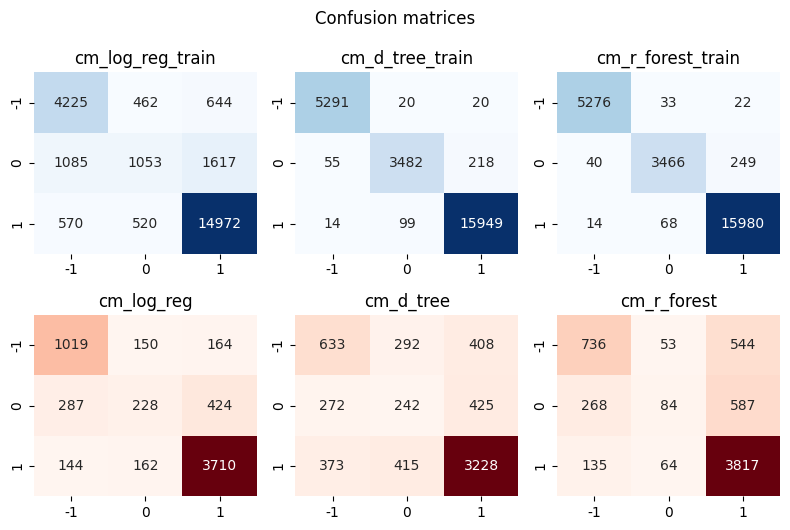

In [31]:
# Confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(8, 5))
axs = axs.flatten()

# Plot the confusion matrices on each subplot
for i, (j_df, nameplot) in enumerate(zip(cm_df, plot_name)):
    axs[i].set_title(f"{nameplot}")
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True Label')
    if i < 3:
        sns.heatmap(j_df, ax=axs[i], annot=True, fmt="d", cmap="Blues", cbar = False)
    else:
        sns.heatmap(j_df, ax=axs[i], annot=True, fmt="d", cmap="Reds", cbar = False)

# Adjust layout and display
plt.tight_layout()
fig.suptitle('Confusion matrices', y=1.05, verticalalignment = 'top')
plt.show()

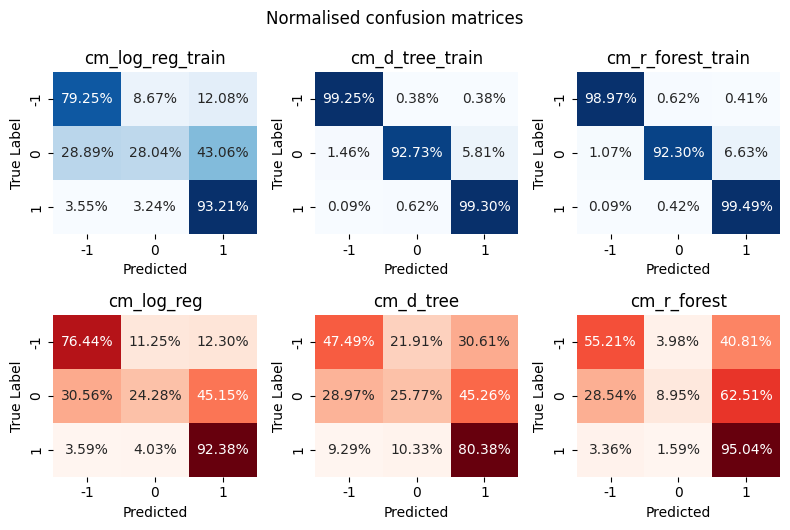

In [32]:
# Normalised confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(8, 5))
axs = axs.flatten()

# Plot the confusion matrices on each subplot
for i, (j_df, nameplot) in enumerate(zip(normalised_cm_df, plot_name)):
    if i < 3:
        sns.heatmap(j_df, ax=axs[i], annot=True, fmt=".2%", cmap="Blues", cbar = False)
    else:
        sns.heatmap(j_df, ax=axs[i], annot=True, fmt=".2%", cmap="Reds", cbar = False)
    axs[i].set_title(f"{nameplot}")
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True Label')

# Adjust layout and display
plt.tight_layout()
fig.suptitle('Normalised confusion matrices', y=1.05, verticalalignment = 'top')
plt.show()

## Accuracy

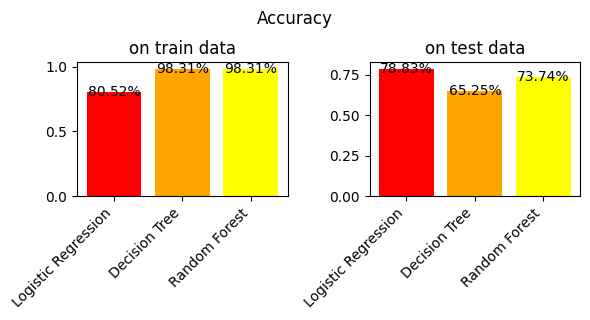

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
label = ['Logistic Regression', 'Decision Tree', 'Random Forest']

# On training data

value_train = [training_data_accuracy_log_reg, training_data_accuracy_d_tree, training_data_accuracy_r_forest]
axs[0].bar(label, value_train, color=['red', 'orange', 'yellow'])
    # Add value labels to each bar
for i, v in enumerate(value_train):
    axs[0].text(i, v, f"{v * 100:.2f}%", ha='center', va='center')
axs[0].set_title('on train data')
axs[0].set_xticklabels(label, rotation=45, ha='right')

# On testing data
value_test = [testing_data_accuracy_log_reg, testing_data_accuracy_d_tree, testing_data_accuracy_r_forest]

axs[1].bar(label, value_test, color=['red', 'orange', 'yellow'])
    # Add value labels to each bar
for i, v in enumerate(value_test):
    axs[1].text(i, v, f"{v * 100:.2f}%", ha='center', va='center')
axs[1].set_title('on test data')
axs[1].set_xticklabels(label, rotation=45, ha='right')


# Adjust layout and display
plt.tight_layout()
fig.suptitle('Accuracy', y=1.05, verticalalignment = 'top')
plt.show()

## Conclusion

This project evaluated the performance of three models: Logistic Regression, Decision Tree, and Random Forest, in predicting the label variable with three classes: -1, 0, and 1.

**1. Accuracy**
- Random Forest and Decision Tree models exhibited higher average accuracy on training dataset
- Logistic Regression model exhibited highest average accuracy on testing dataset, 4% higher than that of Random Forest.

**2. True Positive Rates**
- Class -1: Both Logistic Regression and Random Forest performed similarly well in identifying true negatives for this class
- Class 0: While Random Forest performed better in indentifying true positive for this class on training dataset, it exhibited a tendency to classify instances from the test dataset as false positive.
- Class 1: Random Forest consistently demonstrated the highest true positive rate.

In short, Logistic Regression and Random Forest demonstrated more balanced performance across different classes and datasets

# Using trained model(s) for prediction

In [ ]:
# loading the saved model
loaded_model_log_reg = pickle.load(open('....../trained_models/trained_model_log_reg.sav', 'rb'))
loaded_model_d_tree = pickle.load(open('....../trained_models/trained_model_d_tree.sav', 'rb'))
loaded_model_r_forest = pickle.load(open('....../trained_models/trained_model_r_forest.sav', 'rb'))

In [35]:
sample1 = "tạm được"
sample1 = extract_embedding_batch([sample1])

prediction1 = loaded_model_log_reg.predict(sample1)
prediction2 = loaded_model_d_tree.predict(sample1)
prediction3 = loaded_model_r_forest.predict(sample1)

print(prediction1)
print(prediction2)
print(prediction3)

[0]
[0]
[0]


In [36]:
sample2 = "Áo xấu, mặc hai lần là rách"
sample2 = extract_embedding_batch([sample2])

prediction1 = loaded_model_log_reg.predict(sample2)
prediction2 = loaded_model_d_tree.predict(sample2)
prediction3 = loaded_model_r_forest.predict(sample2)

print(prediction1)
print(prediction2)
print(prediction3)
     

[-1]
[-1]
[1]


In [37]:
sample3 = "Hàng đẹp giá cả phải chăng. Shop giao hàng đúng thời hạn."
sample3 = extract_embedding_batch([sample3])

prediction1 = loaded_model_log_reg.predict(sample3)
prediction2 = loaded_model_d_tree.predict(sample3)
prediction3 = loaded_model_r_forest.predict(sample3)

print(prediction1)
print(prediction2)
print(prediction3)

[1]
[0]
[1]
